<a href="https://colab.research.google.com/github/roderickperez/PINN/blob/master/PINN_2D_DiffusionEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN
Tutorial 4: Diffusion (2D) Equation

Reference: Juan Toscano (Github: jdtoscano94)

https://github.com/jdtoscano94/Learning-PINNs-in-Pytorch-Physics-Informed-Machine-Learning/blob/main/4_DiffusionEquation.ipynb

## 0. Install Libraries

In [1]:
! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Import Libraries

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

## 2. Setup parameters and constants

In [4]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


In [5]:
steps = 20000
lr = 1e-3

layers = np.array([2,32,32,1]) # 2 hidden layers

# To generate new data:
x_min = -1
x_max = 1
t_min = 0
t_max = 1
total_points_x = 200
total_points_t = 100

Nu = 100 # Nu: Number of training points 
Nf = 10000 # Nf: Number of collocation points (Evaluate PDE)

## 3. Define Function

### Auxilary Functions

#### Plot3D

In [6]:
def plot(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="jet", vmin = -1, vmax = 1)
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()

In [7]:
def plot_(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="jet", vmin = -1, vmax = 1)
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()

###  Diffusion Equation
https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html

$$\frac{\partial y}{\partial t}=\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(-\pi x)-\pi^2 sin(\pi x))$$

where 
$$x \in [-1, 1]$$

$$t \in [0, 1]$$

**Initial Conditions**

$$y(x, 0) = sin(\pi x)$$

**Boundary Conditions**

$$y(-1, t) = 0$$

$$y(1, t) = 0$$

Exact Solution

$$y(x,t) = e^{-t}sin(\pi x)$$

---

## Analysis

**PDE**

$$\frac{\partial y}{\partial t}=\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(-\pi x)-\pi^2 sin(\pi x))$$

re-arranging the previous equation:

$$\left ( \frac{\partial y}{\partial t} - \frac{\partial^2 y}{\partial x^2} \right ) + e^{-t}(sin(-\pi x)-\pi^2 sin(\pi x)) = 0$$

Exact Solution

In [8]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

The PDE equation is used to get the residual in the Neural Network.

In [9]:
def PDE(x):
  return -1*(np.pi**2)*torch.sin(np.pi*x)

## 4. Define Network Architecture

Following the PyTorch Network Architecture
```python
class networkName(nn.Module):

    def __init__(self, ...):
        super(networkName, self).__init__()
        # Define Network layers
        self.layer1 = nn.XXXX(...)
        self.layer2 = nn.XXXX(...)
        ...
        self.layern = nn.XXXX(...)

    def forward(self, x):
        out = self.layer1
        out = self.layer2
        ...
        out = self.layern

        return out

# Call the model
model = networkName(...)

# Define loss
loss = nn.XXXLoss()
```

In this case, we will follow the following architecture:

*   Activation Function: tanh
*   Loss Function: MSE
*   Initialise neural network as a list using `nn.Modulelist()`


In [10]:
class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a

    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t]) 
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t]) 
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf                   
    def closure(self):
      optimizer.zero_grad()  
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()      
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss

## 5. Data

Generate the analytical solution over the full domain

In [11]:
x = torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t = torch.linspace(t_min,t_max,total_points_t).view(-1,1)

In [12]:
# Create the mesh 
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


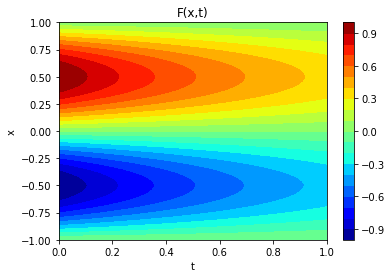

In [13]:
# Evaluate real function
y_real = f_real(X,T)
plot(x,t,y_real) #f_real was defined previously(function)

In [14]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])


## Prepate Data

In [15]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


### Initial Condition

In [16]:
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

### Boundary Conditions

In [17]:
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)

### Get all the training data into the same dataset

In [18]:
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])

### Choose(Nu) points of our available training data:


In [19]:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]

In [20]:
print(idx)

[ 44 110  78 181 285 261  74 270   7 327 264  11  22 146  92 329  66 214
 230 122 266 265  59 140  71 347 198 298 337 272 101  73  70 276 356 166
 108 254 169  97 245  40  13  43 160 179 353 334  64  29 156 200 378  24
 392 322 149 239 313 333 323  57 227 199 138 307 228 229 104 219 131 133
 309 144 184 299  55 129 153  90  33 253 118 300 115  54 357 383  36  91
 226  99 192 100 223 167 216 387 319  37]


In [21]:
len(idx)

100

### Collocation Points (Evaluate our PDe)

Choose (Nf) points(Latin hypercube)

In [23]:
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

In [24]:
print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


## 6. Train Network

In [25]:
# Prepare model
torch.manual_seed(123)

In [26]:
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

In [27]:
X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution 

### Create Model

In [28]:
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [29]:
#optimizer.step(PINN.closure)

### Training Loop

In [30]:
l = []

for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf) # use mean squared error
    l.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
16.872952 --- 0.21578383
0.0023157839 --- 0.040029988
0.0009407956 --- 0.037006427
0.00046192628 --- 0.03623444
0.00022568408 --- 0.03617945
0.00013629891 --- 0.036158804
0.0001279806 --- 0.03609627
8.941313e-05 --- 0.036113016
7.879784e-05 --- 0.036081597
0.00012485115 --- 0.0361414


## 6. Plot Functions

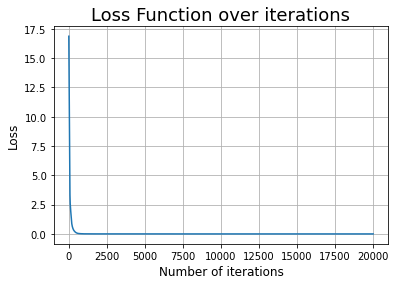

In [31]:
plt.plot(l)
plt.xlabel('Number of iterations', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.title('Loss Function over iterations', fontsize = 18)
plt.grid()

In [32]:
y1=PINN(X_test)

In [33]:
x1=X_test[:,0]
t1=X_test[:,1]

In [34]:
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

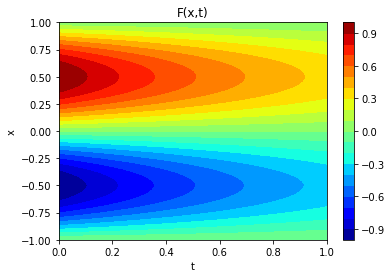

In [35]:
plot(x,t,y_real)

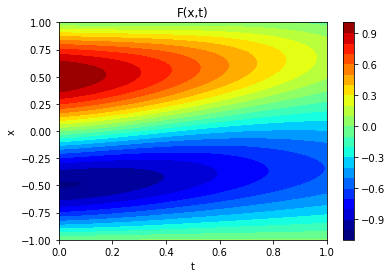

In [36]:
plot_(arr_x1,arr_T1,arr_y1)

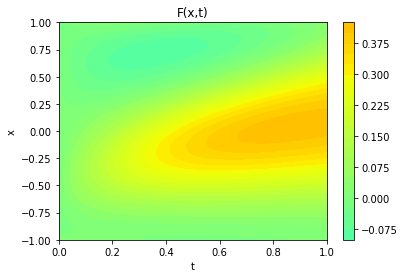

In [37]:
plot_(arr_x1,arr_T1,y_real-arr_y1)